# Simulation de l'algorithme de maintenance

Nous avons à ce stade décidé de la méthode de clustering que nous allons utiliser : le Kmeans.

Mais la **problématique** est alors la suivante :  
    - **A quelle fréquence faut-il actualiser le clustering pour que ceui-ci reste pertinent ?**
    
   
Au fil du temps la qualité du clustering va logiquement se dégrader.

## Démarche : 

Nous allons partir des variables RFM, la démarche serait le même si nous avions le RFMRP mais le nombre de cluster est  plus élevé.

Avant de commencer notre démarche doit être claire :  
- Définir une date de départ proche du début du data set (avec assez de clients quand meme..)  
- Définir une méthode qui va nous permettre de dire si la prédiction du clustering est où non de bonne qualité et définir un seuil en desous duquel le clustering n'est plus acceptable.  
- Nous devrons trouver un pas de temps dt tel que le clustering reste convenable sur la période t + dt  

## Définir une date de départ

Au delà de définir une date de départ nous devons pourvoir créer un dateframe RFM actualisé à la date de la simulation.
Effectivement pour les clients qui ont commandé plus d'une fois la valeur du montant total des dépenses va évoluée au cours du temps. 
Nous allons donc coder une fonction qui nous permet d'avoir un jeu de donnée en concordance avec une date donnée.

### Lecture des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn import decomposition
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from kneed import KneeLocator

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.features.pcoords import parallel_coordinates
import plotly.express as px
import time
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
data_X = pd.read_csv("data_maj.csv")
data_X.drop(columns = 'Unnamed: 0', inplace = True)


In [3]:
data_X

,order_id,order_status,order_purchase_timestamp,order_item_id,seller_id,price,freight_value,seller_city,seller_state,seller_lat,...,customer_state,customer_lat,customer_lng,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name_english,catégori cluster
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,1,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,maua,SP,-23.675542,...,SP,-23.583452,-46.586284,2,voucher,1,18.59,4,géneral maison,maison / construction
1,128e10d95713541c87cd1a2e48201934,delivered,2017-08-15 18:29:31,1,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,maua,SP,-23.675542,...,SP,-23.564977,-46.536043,1,credit_card,3,37.77,4,géneral maison,maison / construction
2,0e7e841ddf8f8f2de2bad69267ecfbcf,delivered,2017-08-02 18:24:47,1,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,7.78,maua,SP,-23.675542,...,SP,-23.532175,-46.626106,1,credit_card,1,37.77,5,géneral maison,maison / construction
3,bfc39df4f36c3693ff3b63fcbea9e90a,delivered,2017-10-23 23:26:46,1,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,14.10,maua,SP,-23.675542,...,SC,-27.553442,-48.500027,1,boleto,1,44.09,3,géneral maison,maison / construction
4,5f49f31e537f8f1a496454b48edbe34d,delivered,2017-08-24 11:31:28,2,3504c0cb71d7fa48d967e0e4c94d59d9,46.80,67.70,maua,SP,-23.675542,...,SP,-23.555460,-46.639994,1,credit_card,1,127.45,1,géneral maison,maison / construction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108989,872b07190c0c9c0f13475d2141c4036a,delivered,2018-07-03 10:10:12,2,7c5b05cbdb5542049f38d90d7815b97d,64.99,19.37,sao paulo,SP,-23.405387,...,PA,-1.463764,-48.488360,1,credit_card,1,168.72,5,livres,divertissement / business et autres
108990,522eec5aa38ae3153b1c1a94e013947e,delivered,2018-07-05 16:25:40,1,7c5b05cbdb5542049f38d90d7815b97d,44.99,18.42,sao paulo,SP,-23.405387,...,PR,-25.521533,-48.528872,1,boleto,1,63.41,1,livres,divertissement / business et autres
108991,1dbff949801376b8795a093d31cfe205,delivered,2018-05-16 14:50:54,1,7c5b05cbdb5542049f38d90d7815b97d,58.99,7.39,sao paulo,SP,-23.405387,...,SP,-23.721535,-46.390913,1,credit_card,1,66.38,5,livres,divertissement / business et autres
108992,6775b950cdc4da0ce39b261032f92c84,delivered,2018-06-13 12:19:26,1,7c5b05cbdb5542049f38d90d7815b97d,23.99,7.43,sao paulo,SP,-23.405387,...,SP,-23.498814,-46.705270,1,boleto,1,31.42,5,livres,divertissement / business et autres


In [6]:
data_X['order_purchase_timestamp'] =  pd.to_datetime(data_X['order_purchase_timestamp'])

In [4]:
def relative_rfm_date(data_X, date):
    data_X_date = data_X[data_X["order_purchase_timestamp"] < date]
    data_rfm = pd.DataFrame(columns=['customer_unique_id','récence','fréquence','montant'])
    data_rfm['customer_unique_id'] = data_X_date['customer_unique_id'].unique()
    
    # La récence
    data_full_rec = data_X_date.sort_values(by = 'order_purchase_timestamp') 
    data_full_rec = data_full_rec.drop_duplicates(subset='customer_unique_id', keep = 'last')
    data_full_rec = data_full_rec[['customer_unique_id','order_purchase_timestamp']]
    data_rfm =  pd.merge(data_rfm,data_full_rec, on="customer_unique_id")
    data_rfm['récence'] = data_rfm['order_purchase_timestamp'].values
    data_rfm = data_rfm.drop(columns = ['order_purchase_timestamp'])
    
    min_date = data_rfm['récence'].min()
    data_rfm['récence'] = data_rfm['récence'] - min_date
    
    def lambda_recence(x):
        return x.days

    data_rfm['récence'] = data_rfm['récence'].apply(lambda_recence)
    # Il est important de noter qu'ici nous avons - min_date et non - max_date, donc les valeurs vont 
    # être positives. l'idée est de ne pas impacter la valeur de la récence au cours du temps et donc qu'elle ne 
    # dépende plus de la date relative.
    
    #La fréquence
    nb_commandes_client = data_X_date[['order_id','customer_unique_id']]
    # On supprime les lignes dupliquées pour les cas ou il y a plusieurs articles
    nb_commandes_client.drop_duplicates(keep = 'first', inplace = True)
    nb_commandes_client = pd.DataFrame(nb_commandes_client.groupby(by = ['customer_unique_id'])['order_id'].count()).reset_index()
    nb_commandes_client = nb_commandes_client.rename(columns={"order_id": "nb_commandes"})
    
    data_rfm =  pd.merge(data_rfm, nb_commandes_client, on="customer_unique_id")
    data_rfm = data_rfm.drop(columns = ['fréquence'])
    data_rfm = data_rfm.rename(columns={"nb_commandes": "fréquence"})
    
    #Le montant
    data_rfm_montant = data_X_date[['price','freight_value','customer_unique_id']]
    data_rfm_montant['prix_total'] = data_rfm_montant['price'] + data_rfm_montant['freight_value'] 
    data_rfm_montant.drop(columns = ['price','freight_value'], inplace = True)
    data_rfm_montant = data_rfm_montant.groupby(by = 'customer_unique_id')['prix_total'].sum()
    data_rfm_montant = pd.DataFrame(data_rfm_montant).reset_index()
    data_rfm =  pd.merge(data_rfm, data_rfm_montant, on="customer_unique_id")
    data_rfm = data_rfm.drop(columns = ['montant'])
    data_rfm = data_rfm.rename(columns={"prix_total": "montant"})
    data_rfm.drop(columns = 'customer_unique_id', inplace = True)
    return data_rfm

Nous avons maintenant la possibilité de créer notre dataframe à partir d'une date donnée  
**Exemple :**

In [56]:
a = relative_rfm_date(data_X, pd.to_datetime('2017-04-22'))
a

,récence,fréquence,montant
0,211,1,260.51
1,186,1,34.86
2,187,1,34.86
3,226,1,34.86
4,201,1,82.84
...,...,...,...
6457,142,1,69.45
6458,158,1,134.00
6459,174,1,131.51
6460,34,1,150.99


In [40]:
type(a["récence"].iloc[0].days)

int

In [23]:
pd.to_datetime('2018-05-16') + pd.Timedelta(1, "d")

Timestamp('2018-05-17 00:00:00')

**Il nous faut maintenant définir une date à partir de laquelle commencer le clustering**

Nous allons déterminer une date vérifiant les conditions suivantes :  
- Des clients avec plusieurs commandes
- Des clients avec un montant total élevé
- Une plage de date assez relativement large pour pouvoir dissocier les clients selon leur ancienneté.

In [72]:
data_X['order_purchase_timestamp'].min()

Timestamp('2016-09-04 21:15:19')

In [73]:
data_X['order_purchase_timestamp'].max()

Timestamp('2018-09-03 09:06:57')

Le fichier s'étale donc sur 2 ans.   
Il faut simplement trouver une date à partir de laquelle nos 5 clusters sont bien présents.

Disons 10 mois avant la fin : soit le **2017-11-01**

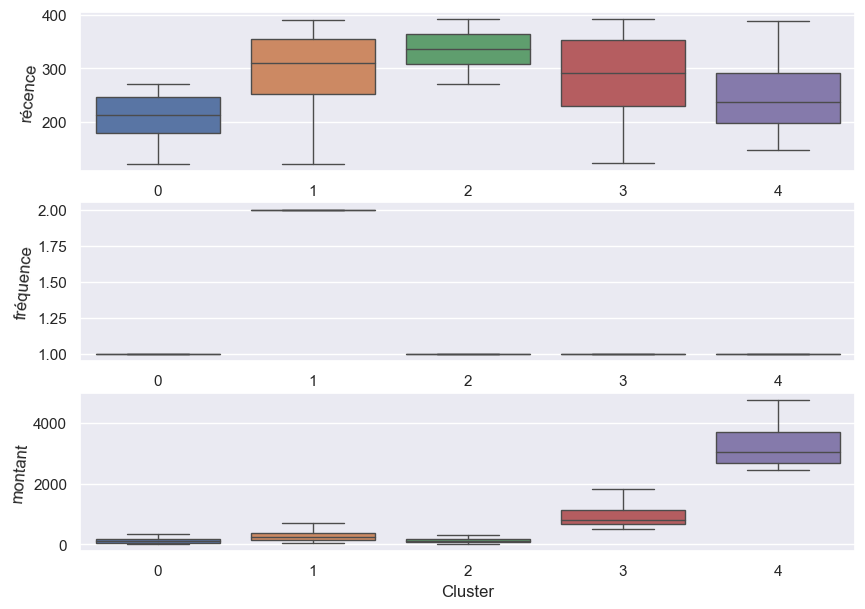

In [379]:
data_X_rfm = relative_rfm_date(data_X, pd.to_datetime('2017-10-01'))

scaler_rfm = StandardScaler()
data_X_rfm_scaled = scaler_rfm.fit_transform(data_X_rfm)

kmeans_params = {
    "max_iter": 10000,
    "random_state": 42,
    'n_clusters' : 5
}
cls = cluster.KMeans(**kmeans_params)
cls.fit(data_X_rfm_scaled)
data_X_labaled = data_X_rfm.copy()
data_X_labaled['Cluster'] =  cls.labels_

plt.style.use('default')
sns.set_theme(style="darkgrid")
liste_variables = data_X_labaled.columns[:-1].values
fig, axs = plt.subplots(nrows=len(liste_variables),  figsize=(10, 7))
for i, col_ in enumerate(liste_variables):
    sns.boxplot(x='Cluster', y= col_, data=data_X_labaled, ax=axs[i],showfliers = False, linewidth=1)
    axs[i].set_ylabel(col_ ,rotation=85)
    

fig.show()

**Un petit problème :**  
Nous voulons que le nature des cluster reste la même au cours du temps. 
Or on peut voir qu'avec 5 clusters le cluster N°4 ne représente pas les clients 'moyennement ancients' mais les clients avec des dépenses "moyennement élevées". Ce phénomène disparait au cours du temps mais pour évité de changer la nature des clusters nous allons fixer leur nombre à 4.

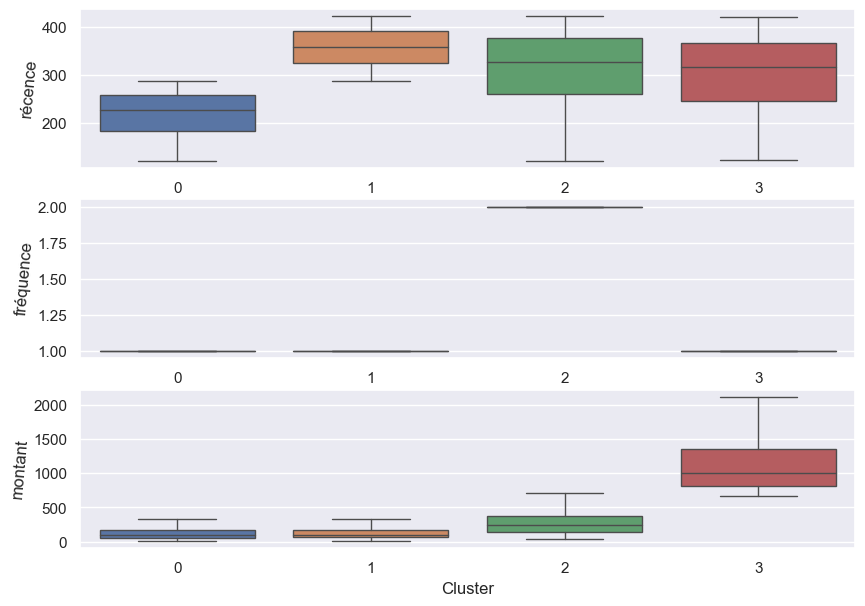

In [382]:
data_X_rfm = relative_rfm_date(data_X, pd.to_datetime('2017-11-01'))

scaler_rfm = StandardScaler()
data_X_rfm_scaled = scaler_rfm.fit_transform(data_X_rfm)

kmeans_params = {
    "max_iter": 10000,
    "random_state": 42,
    "n_clusters" : 4
}
cls = cluster.KMeans(**kmeans_params)
cls.fit(data_X_rfm_scaled)
data_X_labaled = data_X_rfm.copy()
data_X_labaled['Cluster'] =  cls.labels_

plt.style.use('default')
sns.set_theme(style="darkgrid")
liste_variables = data_X_labaled.columns[:-1].values
fig, axs = plt.subplots(nrows=len(liste_variables),  figsize=(10, 7))
for i, col_ in enumerate(liste_variables):
    sns.boxplot(x='Cluster', y= col_, data=data_X_labaled, ax=axs[i],showfliers = False, linewidth=1)
    axs[i].set_ylabel(col_ ,rotation=85)
    

fig.show()

Voilà, maintenant les clusters sont bien différenciés : 
- Un pour la fréquence élvée
- Un autre pour le montant élevé
- Deux autres pour l'ancienneté 

Ils resterons de même nature au fil du temps

## Définir une méthode pour étudier la qualité du clustering prédit

Nous allons utiliser l'ARI : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

Cette méthode va nous donner un score entre -1 et 1, prenant en entrée le clustering A et B, plus le score est proche de 1 plus les deux clustering seront similaires.

Il est important de noter que cette méthode ne va pas prendre en compte le numéro des clusters, car comme nous l'avons vu parfois l'odre des clusters peut varier d'un clustering à un autre

In [71]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score([0, 0, 2, 2], [2, 2, 1, 1])

1.0

In [67]:
data_X_rfm['récence_x'].max()

0

In [68]:
data_X_rfm['récence_x'].min()

-729

Le jeu de données s'étale donc sur 729 jours.

## Méthodologie

Nous devons donc trouver un delta en jours tq l'ARI entre les deux clustering calculé de manière directe par Kmeans et le clustering prédit avec le modèle de l'instant précédent 

Commençons par faire un petit test :

In [384]:
# Premiere étape : On calcule le clustering au temps initial

data_X_rfm = relative_rfm_date(data_X, pd.to_datetime('2017-11-01'))

scaler_rfm = StandardScaler()
data_X_rfm_scaled = scaler_rfm.fit_transform(data_X_rfm)

kmeans_params = {
    "max_iter": 10000,
    "random_state": 42,
    "n_clusters" : 4
}
cls = cluster.KMeans(**kmeans_params)
cls.fit(data_X_rfm_scaled)

# 2 : on prédit les numéros de cluster sur un date ulterieure (disons 1 mois)

data_X_rfm = relative_rfm_date(data_X, pd.to_datetime('2017-12-01'))
data_X_rfm_scaled = scaler_rfm.transform(data_X_rfm)

label_predict = cls.predict(data_X_rfm_scaled)

# 3 : On calcule les vrais labels cette date  :
scaler_rfm = StandardScaler()
data_X_rfm_scaled = scaler_rfm.fit_transform(data_X_rfm)
cls = cluster.KMeans(**kmeans_params)
cls.fit(data_X_rfm_scaled)

label_true = cls.predict(data_X_rfm_scaled)

In [385]:
adjusted_rand_score(label_predict,label_true)

0.7663695280194864

Nous pouvons alors constater que au bout d'un mois le score ARI est de 0.76.

In [386]:
data_X_rfm = relative_rfm_date(data_X, pd.to_datetime('2018-07-30'))

scaler_rfm = StandardScaler()
data_X_rfm_scaled = scaler_rfm.fit_transform(data_X_rfm)

kmeans_params = {
    "max_iter": 10000,
    "random_state": 42,
    "n_clusters" : 4
}

cls = cluster.KMeans(**kmeans_params)
cls.fit(data_X_rfm_scaled)

# 2 : on prédit les numéros de cluster sur un date ulterieure (disons 2 mois)

data_X_rfm = relative_rfm_date(data_X, pd.to_datetime('2018-08-30'))
data_X_rfm_scaled = scaler_rfm.transform(data_X_rfm)

label_predict = cls.predict(data_X_rfm_scaled)

# 3 : On calcule les vrais labels cette date  :
scaler_rfm = StandardScaler()
data_X_rfm_scaled = scaler_rfm.fit_transform(data_X_rfm)
cls = cluster.KMeans(**kmeans_params)
cls.fit(data_X_rfm_scaled)

label_true = cls.predict(data_X_rfm_scaled)

In [387]:
adjusted_rand_score(label_predict,label_true)

0.6869070531087973

Ici nous constatons que le clustering est clairement mauvais, et donc qu'il y aurait besoin d'une mise à jour.

Nous contruisons alors une fonction qui va nous permettre de déterminer le delta de mise à jour en fonction d'un seuil donné.

In [431]:
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import RobustScaler


def delta_simulation(data_X, seuil_ari, initial_date, delta_init): 
    conserve_score = []
    conserve_date = []
    # On place un delta en jour, il va dimininuer a chaque itération
    delta = 160 
    # Temps initial
    T0 = initial_date
    # temps initial + delta
    T1 = initial_date + pd.Timedelta(delta_init, "d")
    # Date maximale du fichier client
    max_date = data_X['order_purchase_timestamp'].max()
    #paramètres du Kmeans
    kmeans_params = {
    "max_iter": 10000,
    "random_state": 42,
    "n_clusters" : 4
    }

    while max_date > T1 -  pd.Timedelta(delta_init, "d"):
        data_X_rfm = relative_rfm_date(data_X, T0)

        scaler_rfm = StandardScaler()
        data_X_rfm_scaled = scaler_rfm.fit_transform(data_X_rfm)


        cls = cluster.KMeans(**kmeans_params)
        cls.fit(data_X_rfm_scaled)
        #cls.fit(data_X_rfm)

        # 2 : on prédit les numéros de cluster sur un date 

        data_X_rfm = relative_rfm_date(data_X, T1)
        data_X_rfm_scaled = scaler_rfm.transform(data_X_rfm)

        label_predict = cls.predict(data_X_rfm_scaled)
        #label_predict = cls.predict(data_X_rfm)
        
        # 3 : On calcule les vrais labels cette date  :
        scaler_rfm = StandardScaler()
        data_X_rfm_scaled = scaler_rfm.fit_transform(data_X_rfm)
        cls = cluster.KMeans(**kmeans_params)
        cls.fit(data_X_rfm_scaled)
        #cls.fit(scaler_rfm)
        
        label_true = cls.predict(data_X_rfm_scaled)
        #label_true = cls.predict(scaler_rfm)
        score_ari = adjusted_rand_score(label_predict,label_true)
        #score_mutual = mutual_info_score(label_true, label_predict)
        # On regarde alors si le score est ok
        print(f'pour delta = {delta_init}')
        print(f' entre la date du {T0} et du {T1}')
        print(f' Nous avons un score ARI de  {score_ari}')
        #print(f' Nous avons un Mutual score de  {score_mutual}')
        # On récupère les résultats avec delta init = 10 pour illuster le problème d'août
        if delta_init == 10 :
            conserve_score.append(score_ari)
            conserve_date.append(T1)
            
        
        if score_ari < seuil_ari :
            # Dans ce cas on repart à partir de la date initiale avec un delta de -10jours
            T0 = initial_date
            delta_init = delta_init - 10
            T1 = initial_date + pd.Timedelta(delta_init, "d")
        else :
            T0 = T1
            T1 = T1 + pd.Timedelta(delta_init, "d") 

        
    return delta_init, conserve_score, conserve_date
        

**Un premier test**

In [437]:
delta_init, conserve_score, conserve_date = delta_simulation(data_X, 0.75, pd.to_datetime('2017-11-01'), 40)

pour delta = 40
 entre la date du 2017-11-01 00:00:00 et du 2017-12-11 00:00:00
 Nous avons un score ARI de  0.7048165588783087
pour delta = 30
 entre la date du 2017-11-01 00:00:00 et du 2017-12-01 00:00:00
 Nous avons un score ARI de  0.7663695280194864
pour delta = 30
 entre la date du 2017-12-01 00:00:00 et du 2017-12-31 00:00:00
 Nous avons un score ARI de  0.8458525575031627
pour delta = 30
 entre la date du 2017-12-31 00:00:00 et du 2018-01-30 00:00:00
 Nous avons un score ARI de  0.8080857188610752
pour delta = 30
 entre la date du 2018-01-30 00:00:00 et du 2018-03-01 00:00:00
 Nous avons un score ARI de  0.8776954998723665
pour delta = 30
 entre la date du 2018-03-01 00:00:00 et du 2018-03-31 00:00:00
 Nous avons un score ARI de  0.882731149818634
pour delta = 30
 entre la date du 2018-03-31 00:00:00 et du 2018-04-30 00:00:00
 Nous avons un score ARI de  0.9070180274461819
pour delta = 30
 entre la date du 2018-04-30 00:00:00 et du 2018-05-30 00:00:00
 Nous avons un score ARI 

Summary
To summarise, in the third part of the series we analysed the Clustering performance metrics, focusing in particular on:

Silhouette Score
Rand Index
Adjusted Rand Index
Mutual Information
Calinski-Harabasz Index
Davies-Bouldin Index

**Nous avons un problème :**  
Le score ARI Chute brutalement durant la prériode du 2018-08-09 au 2018-08-19   


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


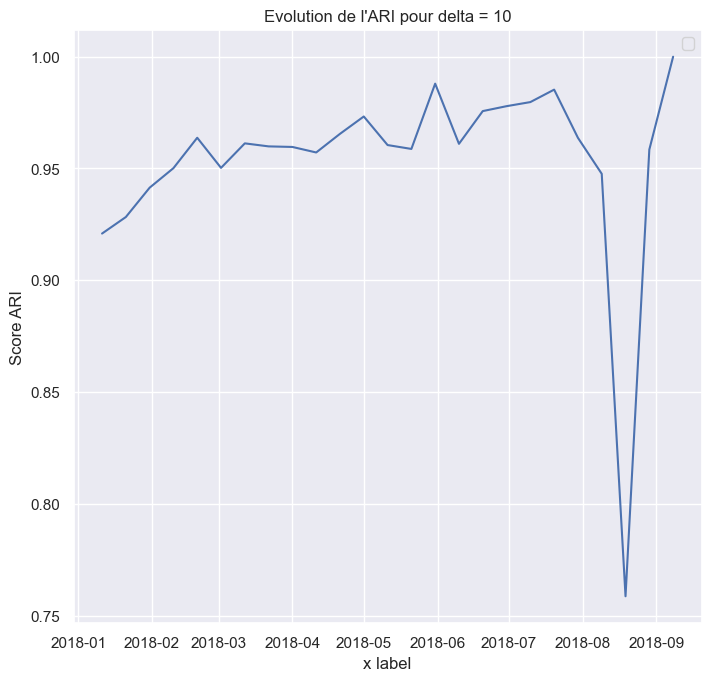

In [297]:
plt.figure(figsize=(7, 6.7), layout='constrained')
plt.plot(conserve_date, conserve_score)  # Plot some data on the (implicit) axes.
plt.xlabel('x label')
plt.ylabel('Score ARI')
plt.title("Evolution de l'ARI pour delta = 10")
plt.legend();

Nous alons donc étudier le scrore ARI jour par jour durant cette période pour déterminer exactement le jour qui pose problème.

In [298]:
delta_init, conserve_score, conserve_date = delta_simulation(data_X, 0.2, pd.to_datetime('2018-08-06'), 1)

pour delta = 1
 entre la date du 2018-08-06 00:00:00 et du 2018-08-07 00:00:00
 Nous avons un score ARI de  0.9925841881035763
pour delta = 1
 entre la date du 2018-08-07 00:00:00 et du 2018-08-08 00:00:00
 Nous avons un score ARI de  0.9848108638185995
pour delta = 1
 entre la date du 2018-08-08 00:00:00 et du 2018-08-09 00:00:00
 Nous avons un score ARI de  0.9980894829076994
pour delta = 1
 entre la date du 2018-08-09 00:00:00 et du 2018-08-10 00:00:00
 Nous avons un score ARI de  0.8090270543247126
pour delta = 1
 entre la date du 2018-08-10 00:00:00 et du 2018-08-11 00:00:00
 Nous avons un score ARI de  0.9754155101308388
pour delta = 1
 entre la date du 2018-08-11 00:00:00 et du 2018-08-12 00:00:00
 Nous avons un score ARI de  0.9985915376675221
pour delta = 1
 entre la date du 2018-08-12 00:00:00 et du 2018-08-13 00:00:00
 Nous avons un score ARI de  0.9910623109855182
pour delta = 1
 entre la date du 2018-08-13 00:00:00 et du 2018-08-14 00:00:00
 Nous avons un score ARI de  0.9

**Le problème est donc situé au 2018-08-10** 

#### Trouver la solution au problème 


Nous allons regarder les statitiques par cluster avant et après cette date pour comprendre ce qui a était modifié

In [14]:
data_X_rfm = relative_rfm_date(data_X, pd.to_datetime('2018-08-09'))

scaler_rfm = StandardScaler()
data_X_rfm_scaled = scaler_rfm.fit_transform(data_X_rfm)

kmeans_params = {
    "max_iter": 10000,
    "random_state": 42,
    "n_clusters" : 4
}
cls = cluster.KMeans(**kmeans_params)
cls.fit(data_X_rfm_scaled)

# 2 : on prédit les numéros de cluster sur un date ulterieure (disons 1 mois)

data_X_rfm = relative_rfm_date(data_X, pd.to_datetime('2018-08-10'))
data_X_rfm_scaled = scaler_rfm.transform(data_X_rfm)

label_predict = cls.predict(data_X_rfm_scaled)

# 3 : On calcule les vrais labels cette date  :
scaler_rfm = StandardScaler()
data_X_rfm_scaled = scaler_rfm.fit_transform(data_X_rfm)
cls = cluster.KMeans(**kmeans_params)
cls.fit(data_X_rfm_scaled)

label_true = cls.predict(data_X_rfm_scaled)

In [15]:
adjusted_rand_score(label_predict,label_true)

0.8090270543247126

In [16]:
pd.DataFrame(label_predict).value_counts()

1    53672
0    29704
3     2621
2     2479
dtype: int64

In [17]:
pd.DataFrame(label_true).value_counts()

1    49034
0    34437
2     2619
3     2386
dtype: int64

**On Affiche les valeurs des variables par clusters**

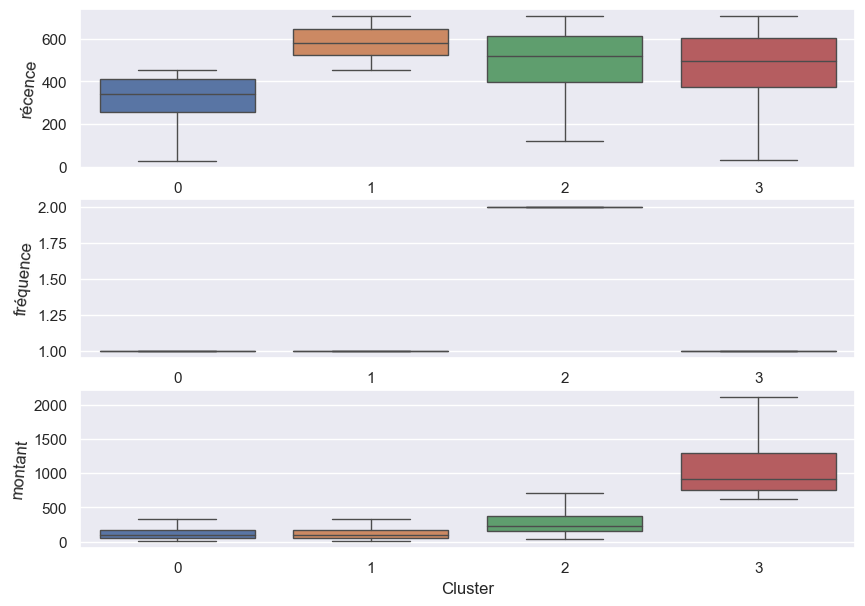

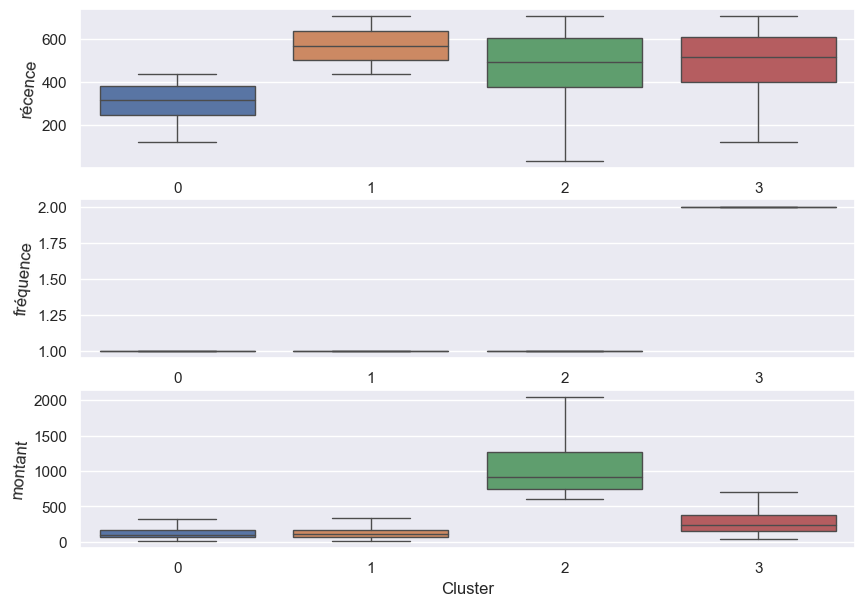

In [18]:
data_X_labaled_true = data_X_rfm.copy()
data_X_labaled_true['Cluster'] =  label_true

data_X_labaled_predict = data_X_rfm.copy()
data_X_labaled_predict['Cluster'] =  label_predict

plt.style.use('default')
sns.set_theme(style="darkgrid")
liste_variables = data_X_labaled_true.columns[:-1].values
fig, axs = plt.subplots(nrows=len(liste_variables),  figsize=(10, 7))
for i, col_ in enumerate(liste_variables):
    sns.boxplot(x='Cluster', y= col_, data=data_X_labaled_true, ax=axs[i],showfliers = False, linewidth=1)
    axs[i].set_ylabel(col_ ,rotation=85)
    

fig.show()

fig, axs = plt.subplots(nrows=len(liste_variables),  figsize=(10, 7))
for i, col_ in enumerate(liste_variables):
    sns.boxplot(x='Cluster', y= col_, data=data_X_labaled_predict, ax=axs[i],showfliers = False, linewidth=1)
    axs[i].set_ylabel(col_ ,rotation=85)
    

fig.show()

**En conclusion sur ce phénomène :**   
Le changement brutal de L'ARI provient du mouvement des clusters qui séparent les clients récents des ancients clients (  N°1 et N°0 ).   
Même avec un update à 1 jours nous avons une forte de chute **-0.2 sur L'ARI**.

Le problème ne provient donc pas des clients en particulier (ouliers ou autre)
(Nous avons fait un test en excluant cette date et le problème est similaire)

In [ ]:
cond1 = data_X['order_purchase_timestamp'] <= pd.to_datetime('2018-08-08')
cond2 = data_X['order_purchase_timestamp'] > pd.to_datetime('2018-08-12')
data_X_sans_10 = data_X[cond1 + cond2 ]
delta_init, conserve_score, conserve_date = delta_simulation(data_X, 0.2, pd.to_datetime('2018-08-06'), 1)

**Nous allons donc étudier l'ARI sur des dates ultérieures au 2018-08-10**

De plus nous allons faire la simulation 6 mois avant cette date car nous avons contater que L'ARI augmente au cours du temps et 10 mois semblait imposer un délait de maintenance trop court.

In [449]:
data_X_inf_10 = data_X[cond1]

In [450]:
delta_init, conserve_score, conserve_date = delta_simulation(data_X_inf_10, 0.75, pd.to_datetime('2018-02-08'), 120)

pour delta = 120
 entre la date du 2018-02-08 00:00:00 et du 2018-06-08 00:00:00
 Nous avons un score ARI de  0.6744561201724025
pour delta = 110
 entre la date du 2018-02-08 00:00:00 et du 2018-05-29 00:00:00
 Nous avons un score ARI de  0.6974338587021108
pour delta = 100
 entre la date du 2018-02-08 00:00:00 et du 2018-05-19 00:00:00
 Nous avons un score ARI de  0.7025724523856743
pour delta = 90
 entre la date du 2018-02-08 00:00:00 et du 2018-05-09 00:00:00
 Nous avons un score ARI de  0.7258875644947116
pour delta = 80
 entre la date du 2018-02-08 00:00:00 et du 2018-04-29 00:00:00
 Nous avons un score ARI de  0.7482446765756222
pour delta = 70
 entre la date du 2018-02-08 00:00:00 et du 2018-04-19 00:00:00
 Nous avons un score ARI de  0.7666491728700723
pour delta = 70
 entre la date du 2018-04-19 00:00:00 et du 2018-06-28 00:00:00
 Nous avons un score ARI de  0.8161974058313238
pour delta = 70
 entre la date du 2018-06-28 00:00:00 et du 2018-09-06 00:00:00
 Nous avons un score 

## Conclusion :

En conclusion nous dirons que le chagement brutal de clustering d'un jour à l'autre nous à poussé à bien comprendre le phénomène en jeu.
Nous proposons finalement un entretient toutes les 10 semaines pour conserver un bon score ARI.   
Au fil du temps il est tout à fait possible que nous augmentions le nombre des clusters, en particulier pendant les périodes où L'ARI chutera brutalement. 
- Par exemple nous aurions proposé au 10 aout 2018 d'ajouter un nouveau cluster, nous serions alors retombés sur le clustering avec K = 5 que nous avions initialement sélectionné. (avec 3 cluster pour la récence)